In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import calendar
import datetime

from scipy import stats
from scipy.stats import ttest_1samp
from scipy.stats import chi2

##### Importing Data

In [2]:
df_NYC=pd.read_csv('../Project/311_Service_Requests_from_2010_to_Present.csv')
df_NYC.head(3)

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,32310363,12/31/2015 11:59:45 PM,01-01-16 0:55,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10034.0,71 VERMILYEA AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.865682,-73.923501,"(40.86568153633767, -73.92350095571744)"
1,32309934,12/31/2015 11:59:44 PM,01-01-16 1:26,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11105.0,27-07 23 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.775945,-73.915094,"(40.775945312321085, -73.91509393898605)"
2,32309159,12/31/2015 11:59:29 PM,01-01-16 4:51,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10458.0,2897 VALENTINE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.870325,-73.888525,"(40.870324522111424, -73.88852464418646)"


In [3]:
#Converting Created Date and Closed Date Datatype Object to Datetime
df_NYC["Created Date"]=pd.to_datetime(df_NYC["Created Date"])
df_NYC["Closed Date"]=pd.to_datetime(df_NYC["Closed Date"])

In [4]:
df_NYC['Request_Closing_Time'] = (df_NYC['Closed Date'] - df_NYC['Created Date'])

In [5]:
df_NYC['Request_Closing_Time'].fillna(value=df_NYC['Request_Closing_Time'].mean(),inplace=True)

In [9]:
df_NYC["Created Year"]=df_NYC["Created Date"].dt.year
df_NYC["Created Month"]=df_NYC["Created Date"].dt.month
df_NYC['Created Month'] = df_NYC['Created Month'].apply(lambda x: calendar.month_abbr[x])
df_NYC['Created Month-Year'] = df_NYC['Created Date'].apply(lambda x: datetime.datetime.strftime(x, '%Y-%m'))

In [7]:
df_NYC['City'].fillna('Unknown City',inplace=True)
df_NYC['Location Type'].fillna('Unknown Location',inplace=True)

In [8]:
def camel_case(city):
    try:
        city = city.split(' ')
        city = ' '.join([x.lower().capitalize() for x in city])
        if city == 'Unknown City':
            return np.nan
        else:
            return city
    except:
        return np.nan
df_NYC['City'] = df_NYC['City'].apply(camel_case)

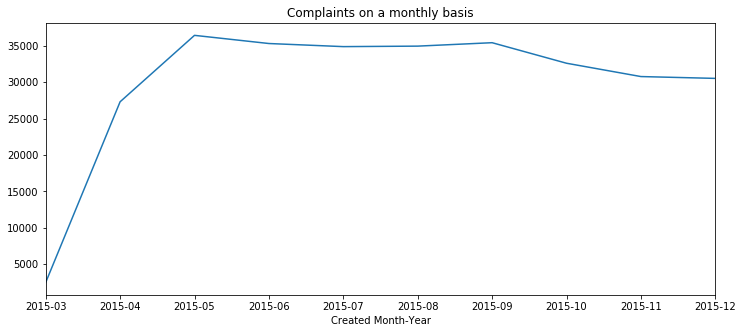

In [14]:
monthly =  df_NYC.groupby('Created Month-Year').size().plot(figsize=(12,5), title='Complaints on a monthly basis')

In [37]:
#Calculating Average Request Closing Time
df_AvgRT=df_NYC[['City','Complaint Type','Request_Closing_Time']]
df_AvgRT['Request_Closing_Time'] = pd.to_datetime(df_AvgRT['Request_Closing_Time']).values.astype(np.int64)
df_AvgRT = df_AvgRT.groupby(['Complaint Type','City'], as_index=False)['Request_Closing_Time'].mean()
df_AvgRT['Avg Request Closing Time'] = pd.to_datetime(df_AvgRT['Request_Closing_Time'], unit='ns').dt.strftime('%H:%M:%S')
print('Average Requesting Closing Time group by City and Complaint Types, Order by Complaint Type')
df_AvgRT

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Average Requesting Closing Time group by City and Complaint Types, Order by Complaint Type


,Complaint Type,City,Request_Closing_Time,Avg Request Closing Time
0,Animal Abuse,Arverne,7.753053e+12,02:09:13
1,Animal Abuse,Astoria,1.800061e+13,05:00:00
2,Animal Abuse,Bayside,1.178824e+13,03:16:28
3,Animal Abuse,Bellerose,4.580886e+13,12:43:28
4,Animal Abuse,Breezy Point,9.408500e+12,02:36:48
...,...,...,...,...
741,Vending,Staten Island,1.537736e+13,04:16:17
742,Vending,Sunnyside,3.500433e+13,09:43:24
743,Vending,Whitestone,8.400000e+12,02:20:00
744,Vending,Woodhaven,1.023283e+13,02:50:32


In [16]:
majorcomplints=df_NYC.groupby("Complaint Type")

sortedComplaintType = majorcomplints.size().sort_values(ascending = False)
sortedComplaintType = sortedComplaintType.to_frame('count').reset_index()

sortedComplaintType.head()

,Complaint Type,count
0,Blocked Driveway,77044
1,Illegal Parking,75361
2,Noise - Street/Sidewalk,48612
3,Noise - Commercial,35577
4,Derelict Vehicle,17718


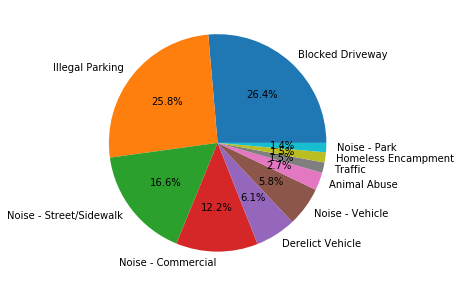

In [17]:
#Visualization on % of top 10 Complaints
sortedComplaintType = sortedComplaintType.head(10)
plt.figure(figsize=(5,5))
plt.pie(sortedComplaintType['count'],labels=sortedComplaintType["Complaint Type"], autopct="%1.1f%%")
plt.show()

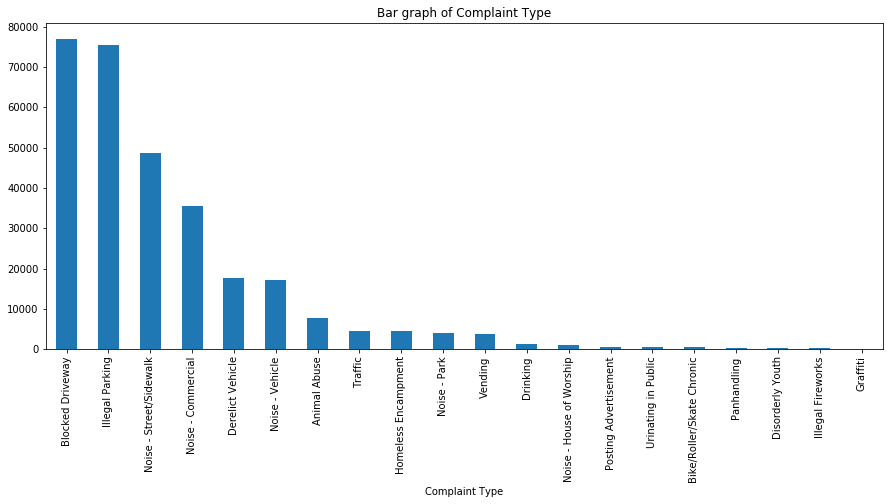

In [23]:
# Visualization of number of complaint type
df_NYC.groupby('Complaint Type').size().sort_values(ascending=False)[:20].plot(kind='bar', figsize=(15,6),
                                                                          title='Bar graph of Complaint Type');

In [12]:
complaintTypecity = pd.DataFrame({'Total Requests':df_NYC.groupby(['Complaint Type','City']).size()}).reset_index()
complaintTypecity

,Complaint Type,City,Total Requests
0,Agency Issues,Unknown City,6
1,Animal Abuse,ARVERNE,38
2,Animal Abuse,ASTORIA,125
3,Animal Abuse,BAYSIDE,37
4,Animal Abuse,BELLEROSE,7
...,...,...,...
777,Vending,SUNNYSIDE,15
778,Vending,Unknown City,7
779,Vending,WHITESTONE,1
780,Vending,WOODHAVEN,6


In [13]:
RequestPerCity=df_NYC.groupby('City').size().sort_values(ascending=False)
RequestPerCity.head(10)

City
BROOKLYN         98307
NEW YORK         65994
BRONX            40702
STATEN ISLAND    12343
JAMAICA           7296
ASTORIA           6330
FLUSHING          5971
RIDGEWOOD         5163
CORONA            4295
WOODSIDE          3544
dtype: int64

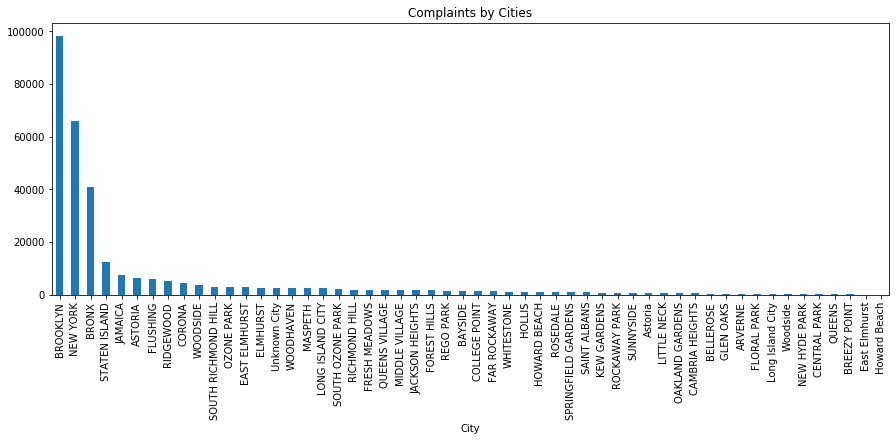

In [15]:
RequestPerCity.plot(kind='bar',figsize=(15,5), title='Complaints by Cities')

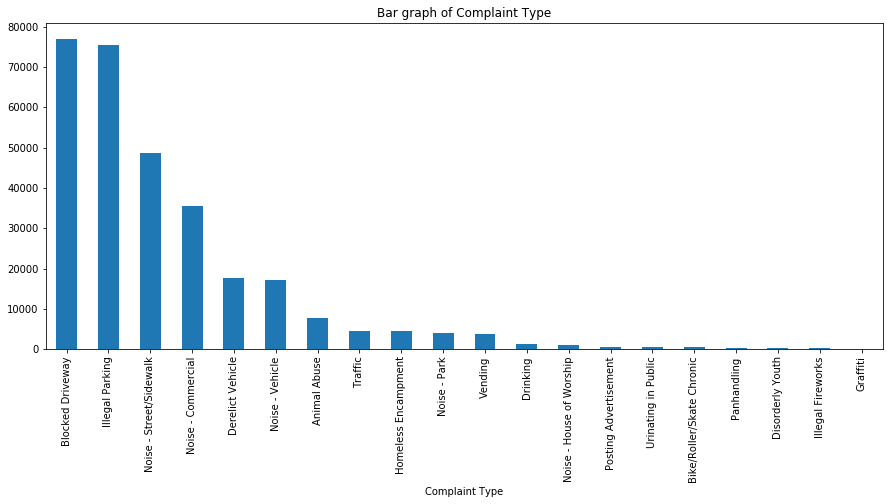

In [22]:
# Visualization of number of complaint type
df_NYC.groupby('Complaint Type').size().sort_values(ascending=False)[:20].plot(kind='bar', figsize=(15,6),
                                                                          title='Bar graph of Complaint Type');

[Text(0, 0, 'Street/Sidewalk'),
 Text(0, 0, 'Store/Commercial'),
 Text(0, 0, 'Club/Bar/Restaurant'),
 Text(0, 0, 'Residential Building/House'),
 Text(0, 0, 'Park/Playground')]

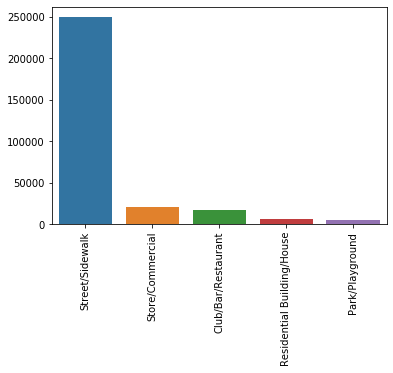

In [25]:
#Visualization of Top 5 Location wise Complaints
Type=df_NYC['Location Type'].value_counts().nlargest(5)
plot4=sns.barplot(x=Type.index,y=Type.values)
plot4.set_xticklabels(plot4.get_xticklabels(),rotation=90)

In [30]:
#Table of Complaints count by City,Complaint Type and Desriptor
df_NYC.groupby(["City","Complaint Type","Descriptor"]).size().sort_values(ascending=False)

City             Complaint Type           Descriptor                 
Brooklyn         Blocked Driveway         No Access                      21422
New York         Noise - Street/Sidewalk  Loud Music/Party               13674
                 Noise - Commercial       Loud Music/Party               10659
Bronx            Blocked Driveway         No Access                       9884
Brooklyn         Noise - Street/Sidewalk  Loud Music/Party                8587
                                                                         ...  
Far Rockaway     Traffic                  Chronic Stoplight Violation        1
Richmond Hill    Traffic                  Truck Route Violation              1
                                          Chronic Stoplight Violation        1
                                          Chronic Speeding                   1
Cambria Heights  Animal Abuse             No Shelter                         1
Length: 1737, dtype: int64

### Statistical Testing

#### Are the type of complaint or service requested and location related?

In [31]:
#Creating a new Dataframe df2 from df_NYC
df2=df_NYC[['City','Complaint Type']]

In [32]:
contingency_table=pd.crosstab(df2["City"],df2["Complaint Type"])
contingency_table.head()

Complaint Type,Animal Abuse,Animal in a Park,Bike/Roller/Skate Chronic,Blocked Driveway,Derelict Vehicle,Disorderly Youth,Drinking,Graffiti,Homeless Encampment,Illegal Fireworks,...,Noise - House of Worship,Noise - Park,Noise - Street/Sidewalk,Noise - Vehicle,Panhandling,Posting Advertisement,Squeegee,Traffic,Urinating in Public,Vending
City,,,,,,,,,,,,,,,,,,,,,
Arverne,38,0,0,35,27,2,1,1,4,0,...,11,2,29,7,1,0,0,0,1,1
Astoria,125,0,15,2734,363,3,35,4,32,4,...,19,61,500,204,1,1,0,47,9,54
Bayside,37,0,0,377,198,1,1,3,2,0,...,2,4,15,16,0,0,0,9,0,2
Bellerose,7,0,1,95,89,2,1,0,1,1,...,1,1,13,10,1,1,0,7,1,0
Breezy Point,2,0,0,3,3,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [63]:
## Applying Chi-squre statistical testing to get p-value and deciding where Complaint Types and Locations/City related to each other

#Observed Values
Observed_Values = contingency_table.values 
Observed_Values
#Expected Values
b=stats.chi2_contingency(contingency_table)
Expected_Values = b[3]

alpha = 0.05
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)

chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)

critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)

#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)
if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")
    
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

chi-square statistic:- 46.00000000000003
critical_value: 3.841458820694124
p-value: 1.182531850218993e-11
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 46.00000000000003
critical_value: 3.841458820694124
p-value: 1.182531850218993e-11
Reject H0,There is a relationship between 2 categorical variables
Reject H0,There is a relationship between 2 categorical variables


##### As p-value is less than alpha value i.e. 0.05 , hence there we can say Complaint Types and Cities are related